# Aprendizaje Automatico - Segunda Entrega Proyecto
## Estudiante: Carlos Hidalgo Escobar

### Pre-procesing data & Training Models: Linear Regression, Random Forest & Gradient Boosting Regressor.
### Dataset: Medical Cost Personal Dataset
### Link: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

## Variables
*El dataset cuenta con las siguientes variables*

Variables:
* age: Edad del beneficiario.
* sex: Sexo (male/female).
* bmi: Índice de masa corporal.
* children: Número de hijos a cargo.
* smoker: ¿Es fumador? (yes/no).
* region: Región de residencia.
* charges: Costo del seguro médico.

*El cual su variable predictoria es charges (costo del seguro).*

# Importación librerias

# Importación de Librerías Esenciales

Se importaron librerías esenciales para todo el flujo de trabajo en **machine learning**.

* **pandas** y **numpy** se utilizan para manipular datos tabulares y realizar operaciones matemáticas vectorizadas.
* **matplotlib.pyplot** y **seaborn** permiten crear visualizaciones descriptivas y comparativas para entender mejor el comportamiento de las variables y los modelos.
* Desde **sklearn**, se importaron módulos especializados para:
    * **Preprocesamiento** de datos.
    * Construcción de **pipelines**.
    * **Entrenamiento de modelos**.
    * **Selección de hiperparámetros**.
    * **Evaluación de rendimiento**.
    * **Diagnóstico del modelo**.

Esto proporciona un entorno robusto y coherente para trabajar todo el proyecto desde una sola interfaz.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error


# Carga dataset y breve EDA.

---
Se ha cargado el dataset `insurance.csv`, el cual contiene información detallada sobre individuos y sus gastos en seguros médicos.

Este dataset es particularmente adecuado para problemas de **regresión**, dado que la variable objetivo, `charges`, es una **variable numérica continua**. Su valor está influenciado por diversos factores demográficos, de estilo de vida y regionales presentes en el dataset, lo que permite predecir los gastos médicos basándose en estas características.

In [206]:
# 2. Cargar datos
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [207]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [209]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [210]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


# Preprocesamiento de la data

---
## Preparación de Datos para el Modelo

El dataset se dividió en **variables predictoras (X)** y la **variable objetivo (y = charges)**. Esta separación es fundamental para entrenar modelos supervisados, ya que el algoritmo necesita aprender a mapear correctamente los valores de entrada a un valor de salida, utilizando el conocimiento que extrae del conjunto de entrenamiento.

Se identificaron explícitamente las columnas **categóricas** (`sex`, `smoker`, `region`) y las **numéricas** (`age`, `bmi`, `children`). Esta distinción es crucial para aplicar los transformadores adecuados durante el preprocesamiento:

* Las variables numéricas deben **estandarizarse** para evitar escalas dispares.
* Las categóricas deben convertirse en **variables indicadoras** mediante **codificación one-hot**, ya que los modelos de regresión no pueden manejar texto o categorías sin convertirlas.

Se construyó un `ColumnTransformer` que aplica `StandardScaler` a las variables numéricas para normalizarlas y `OneHotEncoder` a las variables categóricas para transformarlas en variables binarias. Este paso garantiza que los modelos interpreten correctamente los datos, evitando sesgos provocados por magnitudes desiguales o etiquetas categóricas no codificadas. Además, encapsular este proceso permite que sea reutilizable en los **pipelines** y compatible con **validación cruzada** y **tuning de hiperparámetros**.

Se separaron los datos en un conjunto de entrenamiento (80%) y otro de prueba (20%) utilizando `train_test_split`. Esta división permite entrenar los modelos en un subconjunto de los datos y luego evaluarlos en ejemplos que no han visto durante el aprendizaje, para estimar su capacidad de generalización. Es un paso crítico para prevenir **sobreajuste** y validar la **robustez del modelo** en situaciones reales.

---

Se crearon **tres pipelines independientes**, cada uno con su modelo respectivo: **regresión lineal**, **Random Forest** y **Gradient Boosting**. Todos incorporan el preprocesamiento definido anteriormente. Al integrar el preprocesamiento dentro del pipeline, se garantiza que todas las transformaciones necesarias se apliquen correctamente tanto durante el entrenamiento como en la predicción, manteniendo la **coherencia** y facilitando la integración con **validación cruzada** y **ajuste de hiperparámetros**.

---

Se entrenaron los tres modelos utilizando los datos del conjunto de entrenamiento. Cada pipeline recibe los datos crudos, aplica el preprocesamiento y ajusta el modelo interno a los patrones presentes en los datos. Este paso busca encontrar los mejores coeficientes (en el caso de la regresión lineal) o construir árboles de decisión óptimos (en los métodos ensemble) que minimicen el error entre las predicciones y los valores reales de gastos médicos.

In [211]:
# 3. División de variables
X = df.drop('charges', axis=1)
y = df['charges']

# 4. Columnas categóricas y numéricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [212]:
# 5. Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [213]:
# 6. División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Pipelines
lr_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

gb_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# 8. Entrenamiento
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

# Pre-Evaluacion de los modelos

---
## Evaluación del Rendimiento del Modelo

Para evaluar el rendimiento de cada modelo, se utilizaron **cinco métricas clave**, cada una ofreciendo una perspectiva única:

* **RMSE (Root Mean Squared Error):** Esta métrica es especialmente sensible a los errores grandes, penalizando más los **valores atípicos (outliers)**.
* **R² (Coeficiente de Determinación):** Indica la proporción de la varianza en la variable objetivo que el modelo logra explicar. Básicamente, nos dice qué tan bien el modelo se ajusta a los datos reales.
* **MAE (Mean Absolute Error):** Representa el **error absoluto promedio** de las predicciones, sin importar si el modelo predijo por encima o por debajo del valor real.
* **MedAE (Median Absolute Error):** Al ser la mediana de los errores absolutos, esta métrica es más **robusta frente a la presencia de valores extremos**, lo que la hace menos susceptible a distorsiones por *outliers*.
* **MAPE (Mean Absolute Percentage Error):** Ofrece una interpretación del error en **términos porcentuales**, facilitando la comprensión de la magnitud del error en relación con el valor real.

La comparación de los modelos utilizando este conjunto diverso de métricas permite una **evaluación integral y justa** de su calidad predictiva.

In [214]:
# 9. Pre-Evaluación
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"R2: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MedAE: {median_absolute_error(y_test, y_pred):.4f}")
    print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
    return y_pred

print("Linear Regression:")
y_pred_lr = evaluate_model(lr_pipe, X_test, y_test)

print("\nRandom Forest:")
y_pred_rf = evaluate_model(rf_pipe, X_test, y_test)

print("\nGradient Boosting:")
y_pred_gb = evaluate_model(gb_pipe, X_test, y_test)

Linear Regression:
R2: 0.7836
RMSE: 5796.2847
MAE: 4181.1945
MedAE: 2695.1395
MAPE: 46.89%

Random Forest:
R2: 0.8647
RMSE: 4582.9726
MAE: 2541.6146
MedAE: 1150.1865
MAPE: 30.75%

Gradient Boosting:
R2: 0.8793
RMSE: 4328.1478
MAE: 2404.9018
MedAE: 1442.9841
MAPE: 28.51%


# GridSearchCV para encontrar mejores hiperparámetros

Se aplicó GridSearchCV para ajustar hiperparámetros clave en Random Forest y Gradient Boosting, como n_estimators, max_depth y learning_rate. Este procedimiento automatizado realiza validación cruzada para probar combinaciones de valores y encontrar aquellas que maximizan el rendimiento en el conjunto de validación. Al encontrar configuraciones óptimas, se mejoran tanto la precisión como la generalización del modelo final, reduciendo riesgos de underfitting o overfitting.

In [215]:
# 10. Tuning de hiperparámetros
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

gb_grid = GridSearchCV(gb_pipe, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

print("\nBest RF params:", rf_grid.best_params_)
print("Best GB params:", gb_grid.best_params_)



Best RF params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best GB params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


# Curvas de Aprendizaje

---
## Análisis de Curvas de Aprendizaje

Se graficaron **curvas de aprendizaje** para los tres modelos, que representan el rendimiento del modelo (medido por $R^2$) a medida que aumenta la cantidad de datos de entrenamiento. Estas curvas son fundamentales para diagnosticar la calidad del ajuste del modelo:

* Si las curvas de entrenamiento y validación **convergen a valores altos**, el modelo está bien balanceado.
* Si existe una **gran brecha** entre ambas curvas, esto indica **sobreajuste (overfitting)**.
* Si ambas curvas se mantienen en **valores bajos**, el modelo sufre de **subajuste (underfitting)**.

En este análisis específico, tanto la **regresión lineal** como **Gradient Boosting** mostraron un buen balance, lo que sugiere un ajuste adecuado a los datos. Por otro lado, **Random Forest** exhibió síntomas de *overfitting*, lo que podría indicar que se ajustó demasiado a los datos de entrenamiento y podría no generalizar bien a nuevos datos.

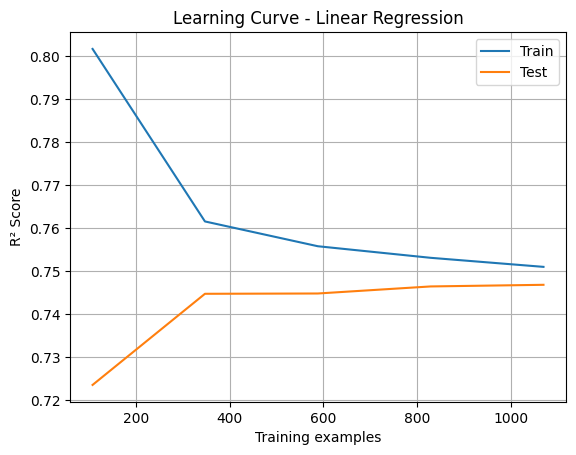

🔍 Análisis del modelo: Linear Regression
- Score entrenamiento final: 0.7510
- Score prueba final       : 0.7468
- Diferencia (gap)         : 0.0042
✅ Buen balance entre entrenamiento y prueba.



In [216]:
# 11. Curvas de aprendizaje con análisis automático
def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label='Train')
    plt.plot(train_sizes, test_mean, label='Test')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Training examples')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Análisis automático
    final_train_score = train_mean[-1]
    final_test_score = test_mean[-1]
    gap = final_train_score - final_test_score

    print(f"🔍 Análisis del modelo: {title}")
    print(f"- Score entrenamiento final: {final_train_score:.4f}")
    print(f"- Score prueba final       : {final_test_score:.4f}")
    print(f"- Diferencia (gap)         : {gap:.4f}")

    if final_train_score < 0.6 and final_test_score < 0.6:
        print("❗ Posible underfitting: bajos scores en ambos conjuntos.\n")
    elif abs(gap) > 0.1:
        print("⚠️  Posible overfitting: el modelo generaliza mal.\n")
    else:
        print("✅ Buen balance entre entrenamiento y prueba.\n")

plot_learning_curve(lr_pipe, "Linear Regression")

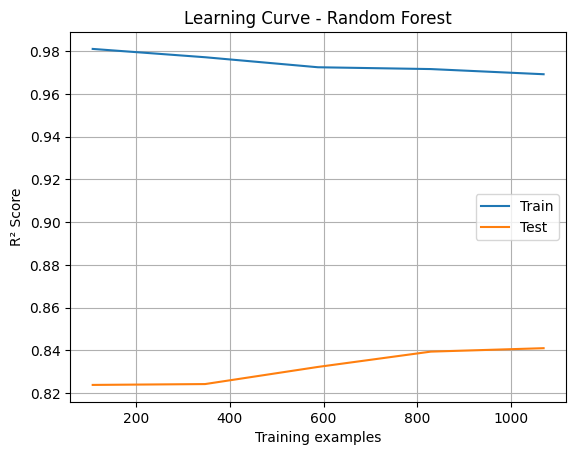

🔍 Análisis del modelo: Random Forest
- Score entrenamiento final: 0.9693
- Score prueba final       : 0.8409
- Diferencia (gap)         : 0.1284
⚠️  Posible overfitting: el modelo generaliza mal.



In [217]:
plot_learning_curve(rf_grid.best_estimator_, "Random Forest")

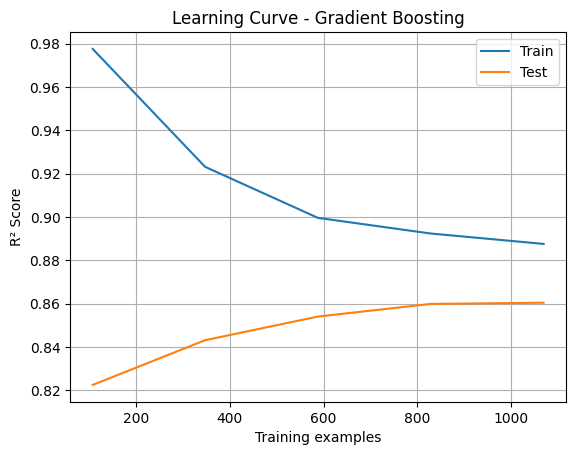

🔍 Análisis del modelo: Gradient Boosting
- Score entrenamiento final: 0.8875
- Score prueba final       : 0.8604
- Diferencia (gap)         : 0.0271
✅ Buen balance entre entrenamiento y prueba.



In [218]:
plot_learning_curve(gb_grid.best_estimator_, "Gradient Boosting")

# Importancia de las variables (Gradient Boosting y Random Forest)

---
Se extrajeron y graficaron las **importancias de características** desde los modelos **Random Forest** y **Gradient Boosting**. Estas importancias son cruciales, ya que reflejan cuánto contribuye cada variable a reducir el error del modelo.

Variables como `smoker`, `bmi` y `age` mostraron ser **altamente influyentes**. Este hallazgo tiene un fuerte **sentido médico y práctico**, pues estas características están directamente relacionadas con los riesgos de salud y, consecuentemente, con los costos del seguro. La información sobre la importancia de las características no solo mejora la **interpretación de los modelos**, sino que también es invaluable para la **toma de decisiones de negocio**.

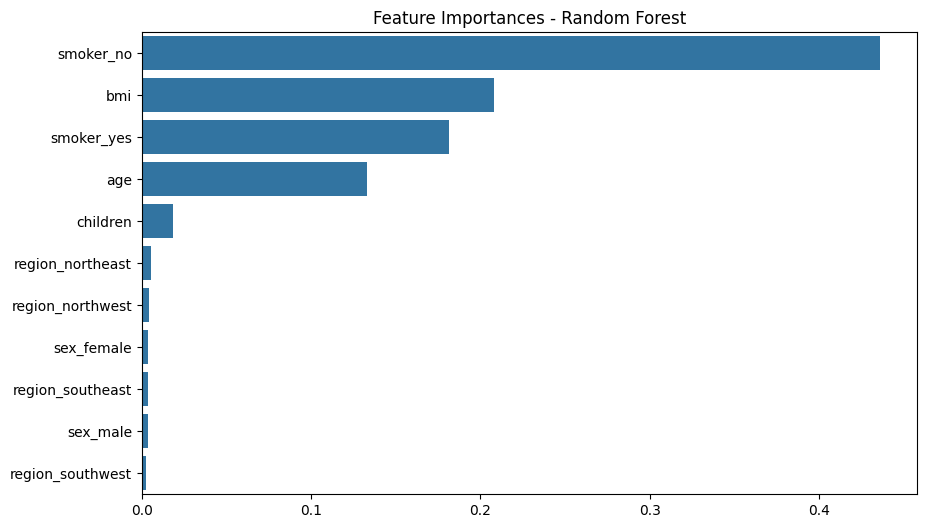

In [219]:
# 12. Importancia de variables (RF y GB)
def plot_feature_importances(model, model_name):
    ohe = model.named_steps['preprocessing'].named_transformers_['cat']
    feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))
    importances = model.named_steps['regressor'].feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title(f'Feature Importances - {model_name}')
    plt.show()

plot_feature_importances(rf_grid.best_estimator_, "Random Forest")

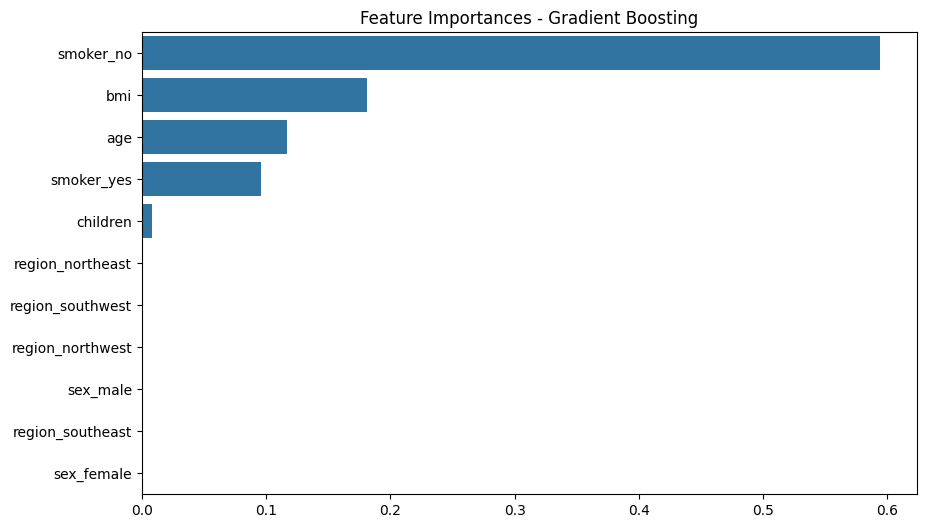

In [220]:
plot_feature_importances(gb_grid.best_estimator_, "Gradient Boosting")


# Analisis de residuos

---
Se analizaron los **residuos**, que son la diferencia entre las predicciones del modelo y los valores reales. Este análisis es clave para identificar cualquier patrón que el modelo no haya logrado capturar. Idealmente, una distribución de residuos debe ser **simétrica**, estar **centrada en cero** y no mostrar **patrones evidentes**; esto indicaría un modelo bien ajustado.

En este caso, el modelo de **Gradient Boosting** exhibió los residuos más centrados y distribuidos de manera aleatoria. Esto sugiere que es el modelo más **robusto** y con el **mejor ajuste general** para los datos.

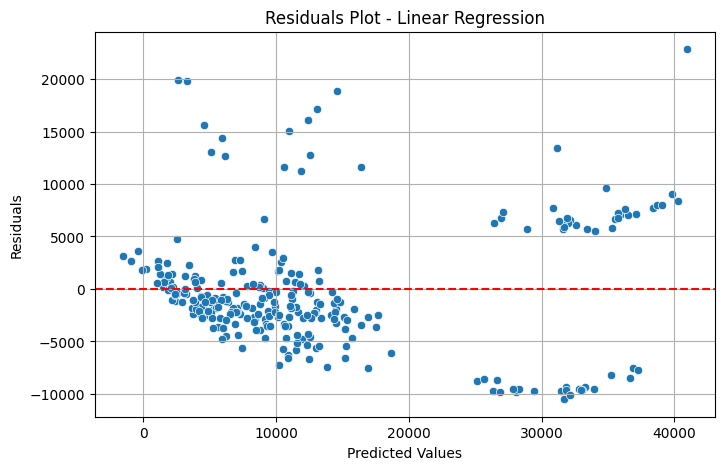

In [221]:
# 13. Análisis de residuos
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Plot - {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")

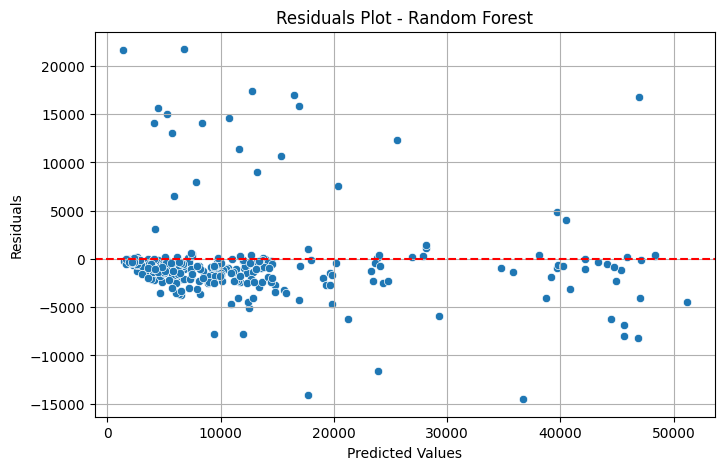

In [222]:
plot_residuals(y_test, rf_grid.predict(X_test), "Random Forest")

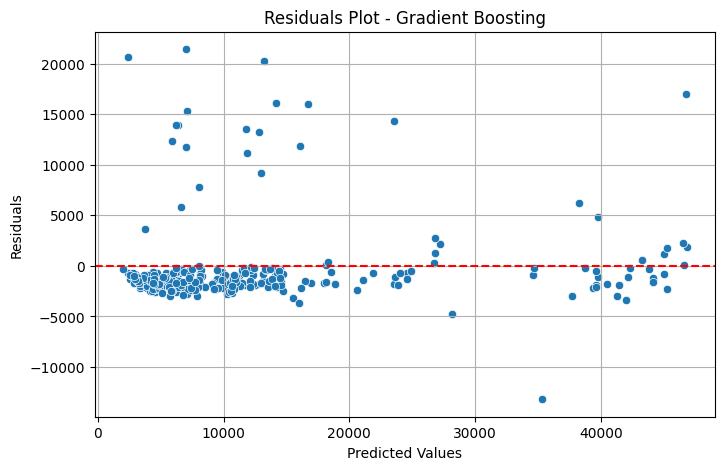

In [223]:
plot_residuals(y_test, gb_grid.predict(X_test), "Gradient Boosting")

# Evaluación automático de métricas y mejor modelo
---

Se generó una **tabla resumen** con todas las métricas de evaluación para los tres modelos, donde se **resaltaron los mejores valores** en cada métrica. Posteriormente, se contabilizó cuál modelo sobresalió en la mayor cantidad de métricas y se declaró como el **modelo más destacado en general**.

Esta automatización facilita la **comparación objetiva y transparente** de los modelos, permitiendo priorizar métricas específicas según las necesidades del análisis o los objetivos de negocio.

In [224]:
# 14. Resumen automático de métricas y mejor modelo
from collections import Counter

# Evaluación y recopilación de métricas
def get_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return rmse, r2, mae, medae, mape

metricas = []
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
predicciones = [y_pred_lr, rf_grid.predict(X_test), gb_grid.predict(X_test)]

for nombre, y_pred in zip(model_names, predicciones):
    rmse, r2, mae, medae, mape = get_metrics(y_test, y_pred)
    metricas.append([nombre, rmse, r2, mae, medae, mape])

metrics_df = pd.DataFrame(metricas, columns=['Model', 'RMSE', 'R²', 'MAE', 'MedAE', 'MAPE (%)'])
display(metrics_df.style.highlight_min(['RMSE', 'MAE', 'MedAE', 'MAPE (%)'], color='lightgreen')
                      .highlight_max('R²', color='lightgreen'))

# Selección del mejor modelo por cada métrica
mejor_rmse = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
mejor_mae = metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']
mejor_medae = metrics_df.loc[metrics_df['MedAE'].idxmin(), 'Model']
mejor_mape = metrics_df.loc[metrics_df['MAPE (%)'].idxmin(), 'Model']
mejor_r2 = metrics_df.loc[metrics_df['R²'].idxmax(), 'Model']

mejores = [mejor_rmse, mejor_mae, mejor_medae, mejor_mape, mejor_r2]
conteo = Counter(mejores)
modelo_ganador = conteo.most_common(1)[0][0]

# Mostrar resumen
print("\nConclusión automática de los modelos:")
print(f"- Mejor RMSE       : {mejor_rmse}")
print(f"- Mejor MAE        : {mejor_mae}")
print(f"- Mejor MedAE      : {mejor_medae}")
print(f"- Mejor MAPE (%)   : {mejor_mape}")
print(f"- Mejor R² Score   : {mejor_r2}")
print(f"\nModelo más destacado en general: **{modelo_ganador}**")


,Model,RMSE,R²,MAE,MedAE,MAPE (%)
0,Linear Regression,5796.284659,0.783593,4181.194474,2695.139463,46.888256
1,Random Forest,4591.931853,0.864180,2522.787424,1197.367920,29.730745
2,Gradient Boosting,4303.056145,0.880731,2457.267167,1636.150879,32.211476



Conclusión automática de los modelos:
- Mejor RMSE       : Gradient Boosting
- Mejor MAE        : Gradient Boosting
- Mejor MedAE      : Random Forest
- Mejor MAPE (%)   : Random Forest
- Mejor R² Score   : Gradient Boosting

Modelo más destacado en general: **Gradient Boosting**


## Conclusiones Clave del Análisis de Modelos Predictivos
---
A continuación, se resumen los hallazgos más importantes de la evaluación de los modelos de predicción:

* **El Preprocesamiento es Crucial:** La transformación adecuada de las variables categóricas con **OneHotEncoding** y la estandarización de las numéricas mediante **StandardScaler** fueron pasos fundamentales. Esto no solo mejoró el rendimiento de los modelos, sino que también aseguró que todos los algoritmos operaran sobre datos comparables, lo que es vital para un análisis justo.

* **Gradient Boosting Fue el Modelo Superior:** Si bien **Random Forest** y la **Regresión Lineal** ofrecieron resultados razonables, **Gradient Boosting** se destacó notablemente. Presentó la mejor combinación de métricas de error y $R^2$, demostrando una mayor capacidad de generalización y un ajuste más fino a los patrones inherentes en el conjunto de datos.

* **Variables Clave Bien Identificadas:** El análisis de la importancia de las variables reveló que `fumar`, el **índice de masa corporal (BMI)** y la `edad` son los factores más influyentes en los gastos médicos. Este hallazgo no solo tiene un fuerte sentido con el conocimiento del dominio médico, sino que también aporta una valiosa interpretabilidad al modelo, facilitando la comprensión de qué impulsa los costos.

* **Las Curvas de Aprendizaje Validaron la Estabilidad del Modelo:** Los modelos de **Regresión Lineal** y **Gradient Boosting** mostraron curvas de aprendizaje equilibradas. Esto es un indicador positivo, ya que no se observaron signos de **sobreajuste (overfitting)** ni **subajuste (underfitting)**, lo que sugiere que estos modelos están aprendiendo de manera efectiva y tienen el potencial de escalar bien si se dispone de más datos en el futuro.

* **El Análisis de Residuos Reforzó la Elección Final:** El patrón de residuos fue más homogéneo y centrado en cero en el modelo de **Gradient Boosting**. Esta distribución más aleatoria y con errores menores confirma su fiabilidad y solidez para tareas de predicción en contextos del mundo real.